## Environment Setup

In [54]:
# Standard Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.express as px
import plotly
import plotly.graph_objs as go
import random
import networkx as nx
from sklearn.metrics.cluster import normalized_mutual_info_score
import math
from scipy.spatial.distance import euclidean
import csv

# Custom Functions from JY_Utils.py
# These include the custom algorithims, as well as helper functions
from JY_Utils import map_values_to_circle, filter_transactions, recurring_streams, label_missed_payments, get_target_dates, nearest_dates

# Automatically reload the functions from JY_Utils before use
%load_ext autoreload
%autoreload 2
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Used for Graphs
#%matplotlib widget

In [ ]:
## If the NMI graph is displaying annotations in each box, this can be fixed by upgrading seaborn
#%pip install seaborn --upgrade

In [ ]:
## Not used currently, but kaleido can be used to export 3d graph images.
#%pip install kaleido

## Feature Engineering

In [3]:
# Read in the confidential dataset from the private folder
df = pd.read_csv('private/Nova_Credit_capstone_project_data_vf.csv')

# convert date to datetime data type
df['date_posted'] = pd.to_datetime(df['date_posted'])

# add day of the month
df['day_of_month'] = df['date_posted'].dt.day

# create a custom field to record the number of months since the start of the dataset
start_date = df['date_posted'].min()
df['months_since_start'] = (df['date_posted'].dt.year - start_date.year) * 12 + (df['date_posted'].dt.month - start_date.month)

# Map day of month to a circle
# This allows the 1st and the 31st to be next to each other the transaction space
df['xcoord'], df['ycoord'] = map_values_to_circle(df['day_of_month'])

# Create a list of each unique applicant's public token
applicants = list(df['public_token'].unique())


## Create a Reproducable Sample of Applicants

Uncomment and run the code below to sample a list of applicants and save the list to a .csv file in the private folder.

In [57]:
#applicant_sample = np.random.choice(applicants, 5)
#applicant_sample = [i for i in applicant_sample]
#
#with open('private/applicant_sample.csv', 'w', newline='') as file:
#    writer = csv.writer(file)
#    for item in applicant_sample:
#        writer.writerow([item])

Run the code below to read the saved list of sample applicants from the private folder.

In [ ]:
applicant_sample = []
with open('private/applicant_sample.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        applicant_sample.append(row[0])

## Visualizing the Transaction Space in 3D (Figures 1.a and 1.b)

The code below visualizes the transaction space in 3D. As time moves forward, transactions will spiral around and up the cylnder.

The 1st cell block will produce the all transactions (recurring and one-off), with colors representing unique transaction descriptions.

The 2nd cell block shows the same transaction set after applying the graph-grouping algorithim. It filteres out one-off transactions and shows colors representing algorithimic groupings of transactions.

NOTE: The 2nd cell block must be run AFTER the Normalized Mutual Information section below, since it uses the payment groupings produced by that section.

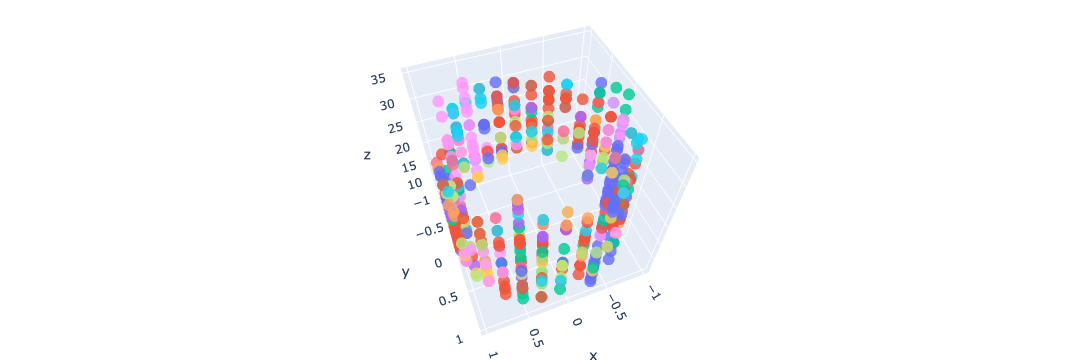

In [237]:
# Figure 1.a

# Filter the transactions
df_filtered_viz = filter_transactions(df=df, 
                            public_token=applicant_sample, 
                            min_exp_threshold=200,
                            max_exp_threshold=15000,
                            min_inc_threshold=200,
                            max_inc_threshold=15000,
                            start_date = '2047-01-10',
                            end_date = '2052-12-10',
                            )

# 
str_grp = [str(x) for x in df_filtered_viz['description'].unique()]
colors = plotly.colors.qualitative.Plotly*300

color_map = dict(zip(str_grp, colors))
# Create a list of colors for each point
point_colors = [color_map[(str_grp)] for str_grp in df_filtered_viz['description']]


date = df_filtered_viz['date_posted'].apply(lambda x: '\n' + str(x))
amt = df_filtered_viz['amount'].apply(lambda x: '\n' + str(x))

# Configure the trace.
trace = go.Scatter3d(
    x=df_filtered_viz['xcoord'],
    y=df_filtered_viz['ycoord'], 
    z=df_filtered_viz['months_since_start'],#/8,
    mode='markers',
    #hovertext= df_filtered_viz['group'] + date + amt,
    marker={
        'size': 7,
        'opacity': 0.8,
        'color': point_colors
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

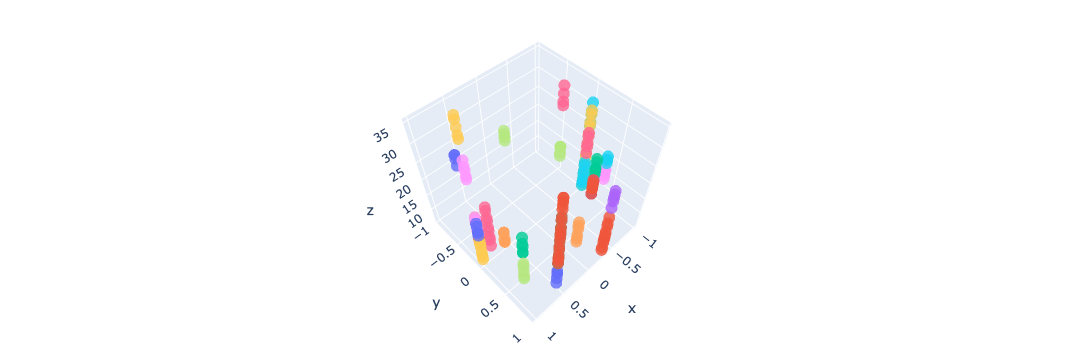

In [280]:
selected_method = 'Near Amount, 3 Day Range'

df_filtered = filter_transactions(df=df, 
                            public_token=applicant_sample, 
                            min_exp_threshold=200,
                            max_exp_threshold=15000,
                            min_inc_threshold=200,
                            max_inc_threshold=15000,
                            start_date = '2047-01-10',
                            end_date = '2052-12-10',
                            )

df_filtered['group'] = '0'
grp = pd.Series(streams[selected_method])

for applicant in applicants:
    #df_filtered['group'][df_filtered['public_token']==applicant] = grp[grp.str[-36:] == applicant]

    indices_to_update = df_filtered['public_token'] == applicant
    values_to_set = grp[grp.str[-36:] == applicant]
    df_filtered.loc[indices_to_update, 'group'] = values_to_set.values
    

df_filtered = df_filtered[~df_filtered['group'].str.startswith('-1')]

df_filtered_viz = df_filtered


str_grp = [str(x) for x in df_filtered_viz['group'].unique()]
colors = plotly.colors.qualitative.Plotly*300
#colors[1] = 'grey'
color_map = dict(zip(str_grp, colors))
# Create a list of colors for each point
point_colors = [color_map[(str_grp)] for str_grp in df_filtered_viz['group']]


date = df_filtered_viz['date_posted'].apply(lambda x: '\n' + str(x))
amt = df_filtered_viz['amount'].apply(lambda x: '\n' + str(x))

# Configure the trace.
trace = go.Scatter3d(
    x=df_filtered_viz['xcoord'],
    y=df_filtered_viz['ycoord'], 
    z=df_filtered_viz['months_since_start'],#/8,
    mode='markers',
    #hovertext= df_filtered_viz['group'] + date + amt,
    marker={
        'size': 7,
        'opacity': 0.8,
        'color': point_colors
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)


## Comparing Recurring Payment Streams Detection Methods with Normalized Mutual Information (Figure 2.a)

Create payment stream groupings for a variety of recurring stream identification methods.

In [272]:
approaches = {'Description-Only':
              {'desc_match_params': ['exact'], # Only exact descriptions are matched
               'amt_match_params': [1000000], # large amt parameters will capture all amounts
               'time_match_params': [1000, 31]},   # large time parameters will capture all time connections
              
              'Exact Amount Only':
              {'desc_match_params': ['any'], # ignore description
               'amt_match_params': [1], # exact amount match only
               'time_match_params': [1000, 31]},   # large time parameters will capture all time connections
              
              'Exact Amount, Exact Day':
              {'desc_match_params': ['any'], # ignore description
               'amt_match_params': [1], # exact amount match only
               'time_match_params': [3, 1]},   # 3 month window, 1-day window

              'Near Amount, 3 Day Range':
              {'desc_match_params': ['any'], # ignore description
               'amt_match_params': [50], # match amounts within $50
               'time_match_params': [3, 3]},   # 3 month window, 1-day window

              'Near Amount, 10 Day Range':
              {'desc_match_params': ['any'], # ignore description
               'amt_match_params': [50], # match amounts within $50
               'time_match_params': [3, 10]}   # # 3 month window, 10-day window

}

streams = {key: [] for key in approaches}


for approach, params in approaches.items():

    for applicant in applicant_sample:
        df_filtered = filter_transactions(df=df, 
                            public_token=applicant, 
                            min_exp_threshold=200,
                            max_exp_threshold=15000,
                            min_inc_threshold=200,
                            max_inc_threshold=15000,
                            start_date = '2047-01-10',
                            end_date = '2052-12-10',
                            )
        stream = recurring_streams(df_filtered, 
                  min_recurrences=4, 
                  methods=params)
        stream = [str(group) + applicant for group in stream]
        
        streams[approach].extend(stream)
        

Display NMI for each pair of methods

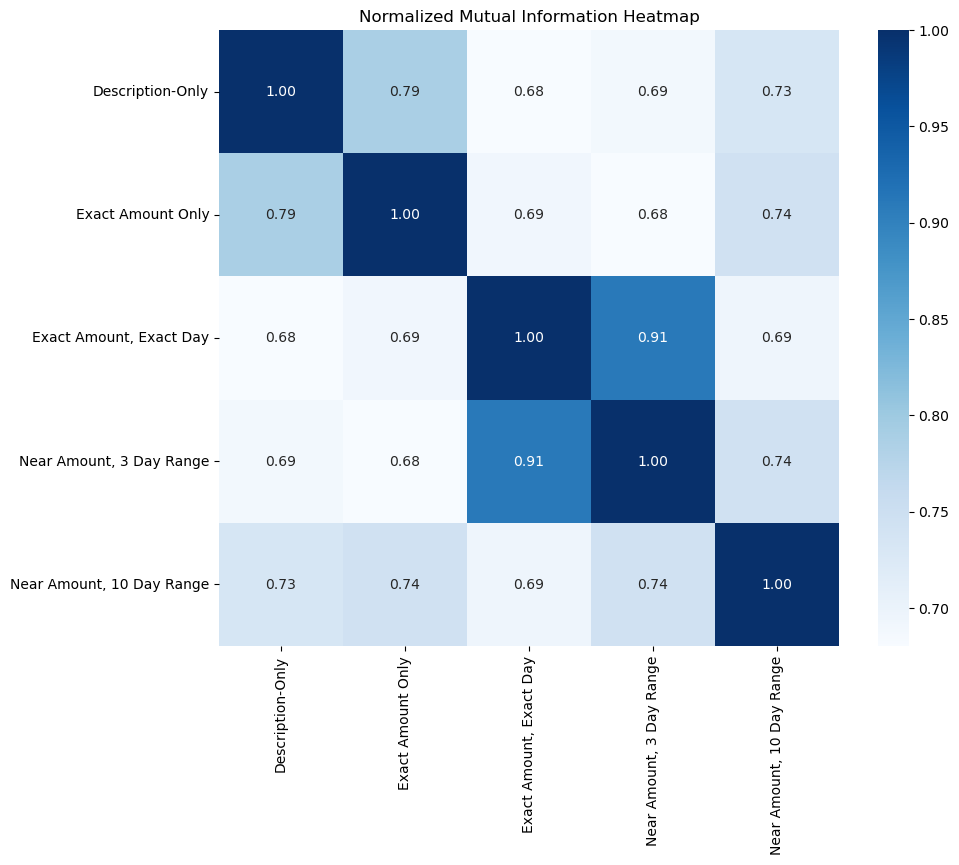

In [273]:
methods = list(streams.keys())
n_methods = len(methods)

# Initialize a matrix to store the NMI scores
nmi_matrix = np.zeros((n_methods, n_methods))

# Calculate NMI scores for each pair of methods
for i in range(n_methods):
    for j in range(n_methods):
        #if i != j:  # Avoid redundant computation; NMI(i, j) == NMI(j, i)
        nmi_score = normalized_mutual_info_score(streams[methods[i]], streams[methods[j]])
        nmi_matrix[i, j] = nmi_score
        nmi_matrix[j, i] = nmi_score  # Symmetric matrix

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(nmi_matrix, cmap="Blues", xticklabels=methods, yticklabels=methods, annot=True, fmt=".2f")#, cbar_kws={'label': 'NMI'})
#sns.heatmap(nmi_matrix, xticklabels=methods, yticklabels=methods, annot=True, cmap='YlGnBu')
plt.title('Normalized Mutual Information Heatmap')
plt.savefig('images/Figure-2a.png', bbox_inches='tight')
plt.show()

## The Tradeoff Between Total Recurring Streams Detected and False Positives

In [278]:
# Calculate the percentage of transactions that are classified as recurring for each method
pct_recurring = []
for desc, stream_ids in streams.items():
    total_pmt = len(stream_ids)
    n_recurring = np.sum([i[0:2]!='-1' for i in stream_ids])
    pct_recurring.append(n_recurring / total_pmt)
    
pd.DataFrame(pct_recurring, streams.keys())

,0
Description-Only,0.691686
Exact Amount Only,0.670901
"Exact Amount, Exact Day",0.174365
"Near Amount, 3 Day Range",0.260970
"Near Amount, 10 Day Range",0.643187


The code below will save a Excel document in the private folder for each recurring payment identification method.

Each Excel document will contain a random sample of 20 payment streams identified by that method.

These samples will be used to assess the accuracy of each method

In [252]:
for method in methods:
    df_filtered = filter_transactions(df=df, 
                            public_token=applicant_sample, 
                            min_exp_threshold=200,
                            max_exp_threshold=15000,
                            min_inc_threshold=200,
                            max_inc_threshold=15000,
                            start_date = '2047-01-10',
                            end_date = '2052-12-10',
                            )

    df_filtered['group'] = '0'
    grp = pd.Series(streams[method])

    for applicant in applicants:
    
        indices_to_update = df_filtered['public_token'] == applicant
        values_to_set = grp[grp.str[-36:] == applicant]
        df_filtered.loc[indices_to_update, 'group'] = values_to_set.values
        
    
    df_filtered = df_filtered[~df_filtered['group'].str.startswith('-1')]


    late_and_missed_pmt_df = label_missed_payments(df_filtered, df_filtered['group'], 3).sort_values(['group', 'date_posted'])

    # Filter the dataframe down to 20 random samples of payment streams
    grp_sample = np.random.choice(late_and_missed_pmt_df['group'], 20)
    sample_df = late_and_missed_pmt_df[late_and_missed_pmt_df['group'].isin(grp_sample)]

    sample_df.to_excel('private/' + method + '.xlsx')
    

Next, I manually evaluate each of the payment streams in each Excel document. 

The number of accurate payment streams is recorded below:

In [263]:
# Mannualy sampled cases

accurate_streams = [13/15,
                    11/17,
                    11/12,
                    12/15, 
                    10/16  
                   ]

accurate_streams

[0.8666666666666667, 0.6470588235294118, 0.9166666666666666, 0.8, 0.625]

Display the Tradeoff

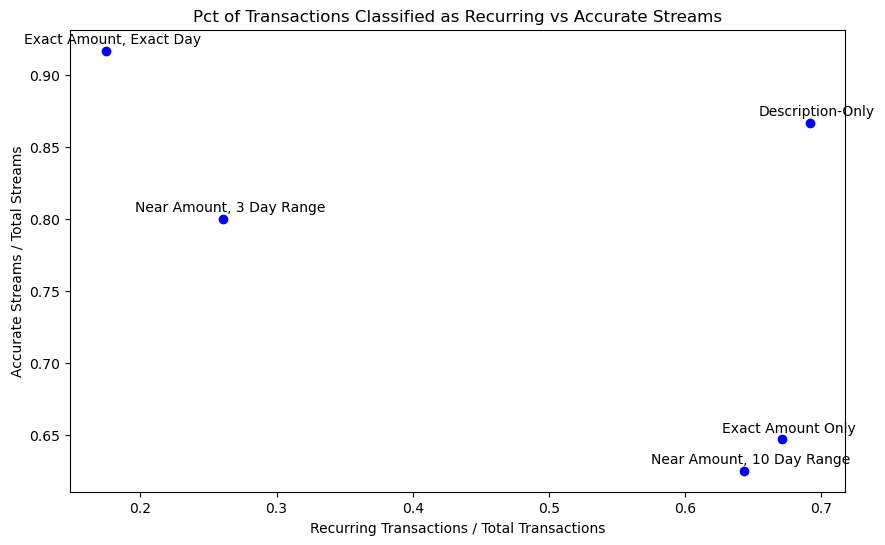

In [279]:
plt.figure(figsize=(10, 6))
plt.scatter(pct_recurring, accurate_streams, color='blue')

# Add labels to each point
for i, label in enumerate(streams.keys()):
    plt.annotate(label, (pct_recurring[i], accurate_streams[i]), textcoords="offset points", xytext=(5,5), ha='center')

# Set the title and labels
plt.title('Pct of Transactions Classified as Recurring vs Accurate Streams')
plt.xlabel('Recurring Transactions / Total Transactions')
plt.ylabel('Accurate Streams / Total Streams')

# Show the plot
plt.savefig('images/Figure-2b.png', bbox_inches='tight')
plt.show()

## Late and Missed Payment Detection

The code below saves the full recurring payment stream data will all labeled late and missed payments for the sample applicants.

In [281]:
selected_method = 'Near Amount, 10 Day Range'

df_filtered = filter_transactions(df=df, 
                            public_token=applicant_sample, 
                            min_exp_threshold=200,
                            max_exp_threshold=15000,
                            min_inc_threshold=200,
                            max_inc_threshold=15000,
                            start_date = '2047-01-10',
                            end_date = '2052-12-10',
                            )

df_filtered['group'] = '0'
grp = pd.Series(streams[selected_method])

for applicant in applicants:
    #df_filtered['group'][df_filtered['public_token']==applicant] = grp[grp.str[-36:] == applicant]

    indices_to_update = df_filtered['public_token'] == applicant
    values_to_set = grp[grp.str[-36:] == applicant]
    df_filtered.loc[indices_to_update, 'group'] = values_to_set.values
    

df_filtered = df_filtered[~df_filtered['group'].str.startswith('-1')]


late_and_missed_pmt_df = label_missed_payments(df_filtered, df_filtered['group'], 3).sort_values(['group', 'date_posted'])

late_and_missed_pmt_df.to_excel('private/full_data.xlsx')


The excel document is saved for reproducablity and read back in below.

In [282]:
edited_df = df = pd.read_excel('private/full_data_edited.xlsx')

Generate the Distribution of Late Payments Chart

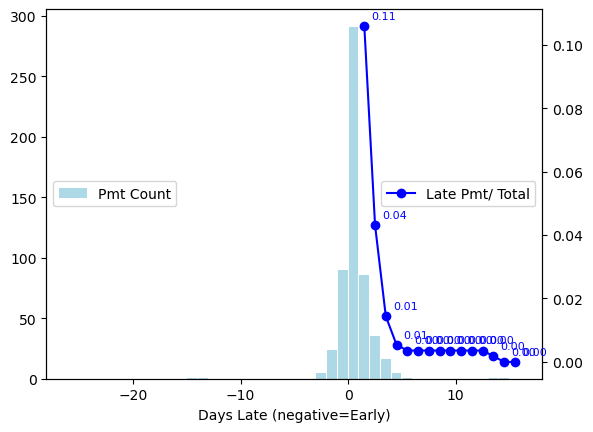

In [283]:
min_value = int(edited_df['days_late'].min())
max_value = int(edited_df['days_late'].max())


# Plot the histogram
#edited_df['days_late'].plot(kind='hist', bins=bins, rwidth=0.8)
fig, ax1 = plt.subplots()
hist, bins, _ = plt.hist(edited_df['days_late'], bins=bins, rwidth=0.9, color='lightblue')

total_pmts = np.sum(hist)

late_pmts = []
for i in range(len(hist)):
    if bins[i] <=0:
        late_pmts.append(0)
    else:
        late_pmts.append(hist[i])

late_pmts = np.cumsum(late_pmts)
late_pmts = [(np.max(late_pmts) - i)/total_pmts for i in late_pmts]
#late_pmts.append(0)


bin_centers = 0.5 * (bins[:-1] + bins[1:])


mask = bin_centers > 1
filtered_bin_centers = bin_centers[mask]
filtered_late_pmts = np.array(late_pmts)[mask]


ax2 = ax1.twinx()
ax2.plot(filtered_bin_centers, filtered_late_pmts, marker='o', color='blue', label='Cumulative Count')

for x, y in zip(filtered_bin_centers, filtered_late_pmts):
    ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(5, 5), textcoords='offset points', fontsize=8, color='blue')


# Customize the plot
ax1.set_xlabel('Days Late (negative=Early)')
#ax1.set_ylabel('Payments')
#ax2.set_ylabel('Percentage Late')
#ax1.set_title('Histogram of Series')

# Add legends
ax1.legend(['Pmt Count'], loc='center left')
ax2.legend(['Late Pmt/ Total'], loc='center right')

#ax1.set_xticks(bin_centers)
#ax1.set_xticklabels([center for center in bin_centers if (center==0)])


# Show the plot
plt.savefig('images/Figure-3a.png', bbox_inches='tight')
plt.show()